# MeanReversion 回测与投资组合优化

在第 4 章中，我们介绍了 `zipline` 来模拟从尾随横截面市场、基本面和另类数据计算 alpha 因子。

现在我们将利用上一章开发的自定义 MeanReversion 因子来利用 alpha 因子来导出买卖信号并对其采取行动。

## 导入

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
from pytz import UTC
import logbook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from logbook import (NestedSetup, NullHandler, Logger, 
                     StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         date_rules,
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output,
                         record, schedule_function,
                         get_open_orders,
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, objective_functions
from pypfopt import expected_returns
from pypfopt.exceptions import OptimizationError

from pyfolio.utils import extract_rets_pos_txn_from_zipline

In [3]:
sns.set_style('whitegrid')

## 日志设置

In [4]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stdout, format_string=format_string, level=WARNING),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## 一些设置

In [5]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
MIN_POS = 5
VOL_SCREEN = 1000

In [6]:
start = pd.Timestamp('2013-01-01', tz=UTC)
end = pd.Timestamp('2017-01-01', tz=UTC)
capital_base = 1e7

## 均值回归因子

In [7]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        factor = df.iloc[-1].sub(df.mean()).div(df.std())
        out[:] = factor

## 创建管道

由 `compute_factors()` 方法创建的管道返回一个表，其中包含 25 只股票的长列和短列，这些股票的最后一个月的收益与其年平均值的负偏差和正偏差最大，并按标准差进行了归一化。它还将范围限制在过去 30 个交易日平均交易量最高的 500 只股票。

In [8]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

`Before_trading_start()` 确保管道的每日执行和结果的记录，包括当前价格。


In [9]:
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))

## 设置再平衡

新的 `rebalance()` 方法将交易订单提交到 `exec_trades()` 方法，用于通过管道标记为多头和空头头寸的资产，正负权重相等。

它还剥离了不再包含在因子信号中的任何当前持有量：

In [10]:
def exec_trades(data, positions):
    """Place orders for assets using target portfolio percentage"""
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [11]:
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place orders"""

    factor_data = context.factor_data
    assets = factor_data.index

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    exec_trades(data, positions={asset: 0 for asset in divest})
    log.info('{} | {:11,.0f}'.format(get_datetime().date(), 
                                   context.portfolio.portfolio_value))

    # get price history
    prices = data.history(assets, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
    
    # get optimal weights if sufficient candidates
    if len(longs) > MIN_POS and len(shorts) > MIN_POS:
        try:
            long_weights = optimize_weights(prices.loc[:, longs])
            short_weights = optimize_weights(prices.loc[:, shorts], short=True)
            
            exec_trades(data, positions=long_weights)
            exec_trades(data, positions=short_weights)
        except Exception as e:
            log.warn('{} {}'.format(get_datetime().date(), e))
    # exit remaining positions
    divest_pf = {asset: 0 for asset in context.portfolio.positions.keys()}
    exec_trades(data, positions=divest_pf)

## 优化投资组合权重

In [12]:
def optimize_weights(prices, short=False):

    returns = expected_returns.mean_historical_return(
        prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # get weights that maximize the Sharpe ratio
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(0, 1),
                           solver='SCS')
    ef.max_sharpe()
    if short:
        return {asset: -weight for asset, weight in ef.clean_weights().items()}
    else:
        return ef.clean_weights()

## 初始化回测

`rebalance()` 方法根据 `schedule_function()` 实用程序在一周开始时设置的 `date_rules` 和 `time_rules` 运行，就在内置 `US_EQUITIES` 日历规定的 `market_open` 之后（有关规则的详细信息，请参阅文档）。

您还可以指定相对金额和最低金额的交易佣金。还有一个选项可以定义滑点，这是交易决策和执行之间价格不利变化的成本

In [13]:
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01))

## 运行算法

该算法在调用 `run_algorithm()` 函数后执行，并返回回测性能 `DataFrame`。

In [14]:
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 15:04:02.206966]: INFO: 2013-01-07 |  10,000,000
[ 15:04:13.017931]: INFO: 2013-01-14 |   9,922,439
[ 15:04:18.557426]: INFO: 2013-01-22 |   9,913,621
[ 15:04:24.402649]: INFO: 2013-01-28 |   9,968,677
[ 15:04:30.172568]: INFO: 2013-02-04 |  10,079,415
[ 15:04:35.682749]: INFO: 2013-02-11 |  10,103,558
[ 15:04:41.171035]: INFO: 2013-02-19 |   9,771,110
[ 15:04:46.530124]: INFO: 2013-02-25 |  10,061,821
[ 15:04:52.090849]: INFO: 2013-03-04 |  10,162,324
[ 15:04:57.114322]: INFO: 2013-03-11 |   9,563,264
[ 15:05:03.300852]: INFO: 2013-03-18 |   9,311,817
[ 15:05:08.414171]: INFO: 2013-03-25 |   9,064,091
[ 15:05:13.263920]: INFO: 2013-04-01 |   8,643,954
[ 15:05:18.577131]: INFO: 2013-04-08 |   8,722,009
[ 15:05:24.124206]: INFO: 2013-04-15 |   8,552,139
[ 15:05:30.197661]: INFO: 2013-04-22 |   8,186,965
[ 15:05:35.699123]: INFO: 2013-04-29 |   9,080,210
[ 15:05:41.221507]: INFO: 2013-05-06 |   8,277,413
[ 15:05:46.886876]: INFO: 2013-05-13 |   8,017,929
[ 15:05:52.532847]: INFO: after

## 提取 pyfolio 输入

`pyfolio` 提供的`extract_rets_pos_txn_from_zipline` 实用程序提取用于计算性能指标的数据。

In [15]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

## 保存与 pyfolio 一起使用的结果

In [16]:
with pd.HDFStore('backtests.h5') as store:
    store.put('returns/pf_opt', returns)
    store.put('transactions/pf_opt', transactions)

In [17]:
with pd.HDFStore('backtests.h5') as store:
    returns_pf = store['returns/pf_opt']
    tx_pf = store['transactions/pf_opt']
    returns_ew = store['returns/equal_weight']
    tx_ew = store['transactions/equal_weight']

## 绘制结果

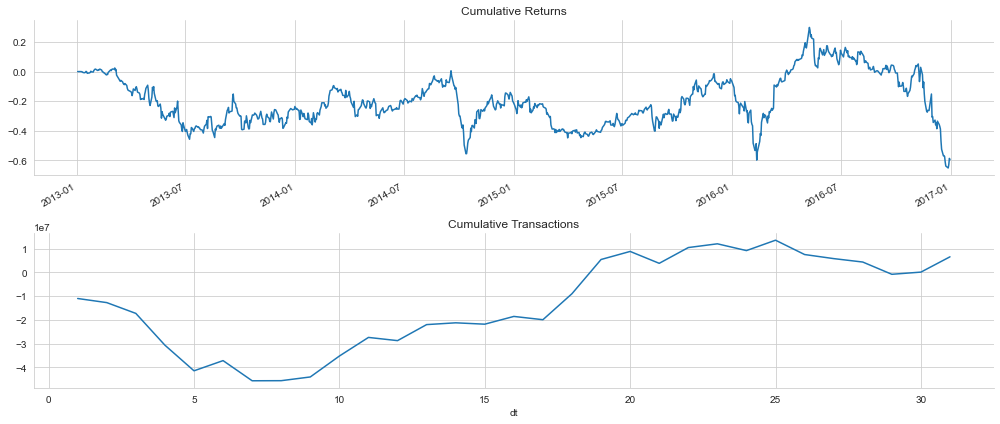

In [18]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
sns.despine()
fig.tight_layout();

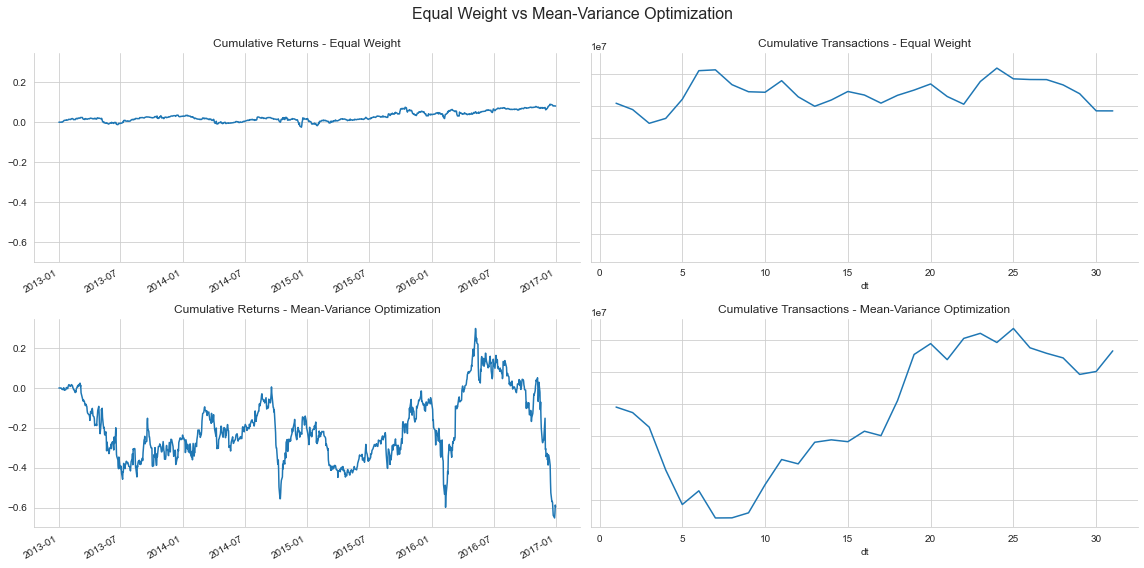

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharey='col')
returns_ew.add(1).cumprod().sub(1).plot(ax=axes[0][0],
                                        title='Cumulative Returns - Equal Weight')
returns_pf.add(1).cumprod().sub(1).plot(ax=axes[1][0],
                                        title='Cumulative Returns - Mean-Variance Optimization')
tx_ew.groupby(tx_ew.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[0][1],
                                                               title='Cumulative Transactions - Equal Weight')
tx_pf.groupby(tx_pf.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1][1],
                                                               title='Cumulative Transactions - Mean-Variance Optimization')
fig.suptitle('Equal Weight vs Mean-Variance Optimization', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)